In [467]:
# Jupyter Notebook'u tam sayfa yapmak için...
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

In [468]:
###############################################################
# Customer Segmentation with RFM
###############################################################

# Customer Segmentation with RFM in 6 Steps

# 1. Business Problem
# 2. Data Understanding
# 3. Data Preparation
# 4. Calculating RFM Metrics
# 5. Calculating RFM Scores
# 6. Naming & Analysing RFM Segments


# Bir e-ticaret şirketi müşterilerini segmentlere ayırıp bu segmentlere göre
# pazarlama stratejileri belirlemek istiyor.

# Buna yönelik olarak müşterilerin davranışlarını tanımlayacağız ve
# bu davranışlarda öbeklenmelere göre gruplar oluşturacağız.

# Veri Seti Hikayesi
#
# https://archive.ics.uci.edu/ml/datasets/Online+Retail+II
#
# Online Retail II isimli veri seti İngiltere merkezli online bir satış mağazasının
# 01/12/2009 - 09/12/2011 tarihleri arasındaki satışlarını içeriyor.

# Değişkenler
# InvoiceNo: Fatura numarası. Her işleme yani faturaya ait eşsiz numara.
# Eğer bu kod C ile başlıyorsa işlemin iptal edildiğini ifade eder.
# StockCode: Ürün kodu. Her bir ürün için eşsiz numara.
# Description: Ürün ismi
# Quantity: Ürün adedi. Faturalardaki ürünlerden kaçar tane satıldığını ifade etmektedir.
# InvoiceDate: Fatura tarihi ve zamanı.
# UnitPrice: Ürün fiyatı (Sterlin cinsinden)
# CustomerID: Eşsiz müşteri numarası
# Country: Ülke ismi. Müşterinin yaşadığı ülke.



# Data Collection & Libraries

In [470]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
import plotly.express as px
import plotly as py
import matplotlib.pyplot as plt
import datetime as dt
import warnings

from collections import Counter
from PIL import Image
from pathlib import Path
from IPython.display import HTML

warnings.filterwarnings("ignore")
py.offline.init_notebook_mode(connected = True)


pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [471]:
sh_2010 = pd.read_excel("online_retail_II.xlsx", sheet_name="Year 2009-2010")
sh_2011 = pd.read_excel("online_retail_II.xlsx", sheet_name="Year 2010-2011")
df_ = pd.concat([sh_2010, sh_2011], ignore_index=True)

In [472]:
df = df_.copy()
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.950,13085.000,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.750,13085.000,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.750,13085.000,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.100,13085.000,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.250,13085.000,United Kingdom


In [473]:
def check_df(dataframe, head):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Duplicated #####################")
    print(dataframe.duplicated().sum())
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### N-Unique #####################")
    print(dataframe.nunique())
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### Quantiles #####################")
    print(dataframe.describe([0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]).T)

In [474]:
check_df(df, 5)

##################### Shape #####################
(1067371, 8)
##################### Duplicated #####################
34335
##################### Types #####################
Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object
##################### N-Unique #####################
Invoice        53628
StockCode       5305
Description     5698
Quantity        1057
InvoiceDate    47635
Price           2807
Customer ID     5942
Country           43
dtype: int64
##################### NA #####################
Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64
##################### Head #####################
  Invoice StockCode                          Descript

# Basic Analysis (EDA)

- Description
- Customer
- Invoice Content
- Countries

In [476]:
# What is the number of unique products?
# Benzersiz ürün sayısı nedir?
df["Description"].nunique()

5698

In [477]:
# How many of which products do you have?
# Hangi ürünlerden kaç tane var?
df["Description"].value_counts().head()

Description
WHITE HANGING HEART T-LIGHT HOLDER    5918
REGENCY CAKESTAND 3 TIER              4412
JUMBO BAG RED RETROSPOT               3469
ASSORTED COLOUR BIRD ORNAMENT         2958
PARTY BUNTING                         2765
Name: count, dtype: int64

In [478]:
# Which is the most ordered product?
# En çok sipariş edilen ürün hangisi?
df.groupby("Description").agg({"Quantity": "sum"}).sort_values("Quantity", ascending=False).head()

,Quantity
Description,
WORLD WAR 2 GLIDERS ASSTD DESIGNS,108545
WHITE HANGING HEART T-LIGHT HOLDER,93050
ASSORTED COLOUR BIRD ORNAMENT,81306
JUMBO BAG RED RETROSPOT,78090
BROCADE RING PURSE,70700


In [479]:
# How many invoices have been issued?
# Toplam kac fatura kesilmiştir?
df["Invoice"].nunique()

53628

In [480]:
# How many customers?
# Kaç müşteri bulunuyor?
df["Customer ID"].nunique()

5942

In [481]:
# what are the most expensive products?
# En pahalı ürünler hangileri?
df.sort_values("Price", ascending=False).head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
748142,C556445,M,Manual,-1,2011-06-10 15:31:00,38970.000,15098.000,United Kingdom
241827,512771,M,Manual,1,2010-06-17 16:53:00,25111.090,NaN,United Kingdom
241824,C512770,M,Manual,-1,2010-06-17 16:52:00,25111.090,17399.000,United Kingdom
320581,C520667,BANK CHARGES,Bank Charges,-1,2010-08-27 13:42:00,18910.690,NaN,United Kingdom
1050063,C580605,AMAZONFEE,AMAZON FEE,-1,2011-12-05 11:36:00,17836.460,NaN,United Kingdom


In [482]:
# Average revenue per invoice?
# (it is necessary to create a new variable by multiplying two variables)
# Fatura başına ortalama gelir?
# (iki değişkeni çarparak yeni bir değişken oluşturmak gerekir)
df["TotalPayment"] = df["Quantity"] * df["Price"]
df["TotalPayment"]/df["Invoice"].nunique()

0         0.002
1         0.002
2         0.002
3         0.002
4         0.001
           ... 
1067366   0.000
1067367   0.000
1067368   0.000
1067369   0.000
1067370   0.000
Name: TotalPayment, Length: 1067371, dtype: float64

In [483]:
# How much income did countries generate?
# Hangi ulke ne kadar kazandırdı?
df.groupby("Country").agg({"TotalPayment": "sum"}).sort_values("TotalPayment", ascending=False).head()

,TotalPayment
Country,
United Kingdom,16382583.897
EIRE,615519.550
Netherlands,548524.950
Germany,417988.561
France,328191.800


# Data Preparation

### Duplicate Entries

In [486]:
duplicate_rows = df.duplicated()
print(duplicate_rows.sum())
print(round((df.duplicated().sum()/df.shape[0])*100, 2))

# df[duplicate_rows]
# print('Duplicate entries: {}'.format(df.duplicated().sum()))
# print('{}% rows are duplicate.'.format(round((df.duplicated().sum()/df.shape[0])*100),2))

34335
3.22


In [487]:
# Drop duplicates
df.drop_duplicates(inplace = True)

In [488]:
# Check again
df.duplicated().sum()

0

### Convert some columns to string data type

### "Cancel" Invoices

In [491]:
# We clean return invoices and debt information from our data set.
# İade faturalarını ve borç bilgilerini veri setimizden temizliyoruz.
# C for Cancel, A for debts
df[df["Invoice"].str.contains("C|A", na=False)].shape

(19110, 9)

In [492]:
# Let's create the df again by subtracting the returns
# Geri dönüşleri çıkararak df'yi yeniden oluşturalım
df = df[~df["Invoice"].str.contains("C|A", na=False)]

In [493]:
df.shape

(1013926, 9)

### Dropping Null Values

In [495]:
# Since we cannot identify products and customers for which we do not have data, we drop rows with missing values from the data.
# Verisine sahip olmadığımız ürünleri ve müşterileri tespit edemeyeceğimiz için kayıp değer olan satırları veriden düşürüyoruz.
#df.isnull().sum()
df.dropna(inplace=True)

In [496]:
check_df(df, 15)

##################### Shape #####################
(779495, 9)
##################### Duplicated #####################
0
##################### Types #####################
Invoice                 object
StockCode               object
Description             object
Quantity                 int64
InvoiceDate     datetime64[ns]
Price                  float64
Customer ID            float64
Country                 object
TotalPayment           float64
dtype: object
##################### N-Unique #####################
Invoice         36975
StockCode        4631
Description      5283
Quantity          438
InvoiceDate     34591
Price             666
Customer ID      5881
Country            41
TotalPayment     3920
dtype: int64
##################### NA #####################
Invoice         0
StockCode       0
Description     0
Quantity        0
InvoiceDate     0
Price           0
Customer ID     0
Country         0
TotalPayment    0
dtype: int64
##################### Head #####################
   

In [497]:
df[df["Price"] < 0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPayment


In [498]:
df["Customer ID"].nunique()

5881

In [499]:
df["Customer ID"].isnull().sum()

0

# Calculating RFM Metrics

- Recency = Analiz tarihi(Bugün) - Son satın alma (Today's date - Last purchase)\
Recency (yenilik, güncellik): Müşterinin son satın almasından bugüne kadar geçen süre.
Diğer bir ifadesiyle “Müşterinin son temasından bugüne kadar geçen süre” dir.

- Frequency: Alışveriş sıklığı, her bir müşterinin belirtilen zaman içerisinde kaç kez alışveriş yaptığı bilgisi.\

- Monetary: Her bir alışverişten kazanılan toplam parasal değer.\

- Tenure: Müşterinin ilk alışverişinden bugüne kadar geçen süre.\

- Basket Size : Monetary / Product count

### Set Analysis Date

In [502]:
df["InvoiceDate"].max()
# Veri setimizdeki en güncel alışveriş tarihi: Timestamp('2011-12-09 12:50:00')

Timestamp('2011-12-09 12:50:00')

In [503]:
# Analysis Date (Todays Date)
# Analiz tarihi(Bugün)
today_date = dt.datetime(2011, 12, 11)
today_date

datetime.datetime(2011, 12, 11, 0, 0)

### Metrics

In [505]:
# # Recency gösterimi
# df.groupby('Customer ID').agg({'InvoiceDate': lambda date: (today_date - date.max()).days})

# # Tenure hesaplaması
# df.groupby('Customer ID').agg({'Tenure': lambda date: (today_date - date.min()).days})

# # Monetary hesaplaması
# df.groupby('Customer ID').agg({'Invoice': lambda Revenue: Revenue.sum()})

# # Frekans gösterimi, her bir müşterinin alışveriş sayısı
# df.groupby('Customer ID').agg({'Invoice': lambda Invoice: Invoice.nunique()})

# Basket Size hesaplaması
# rfm["BasketSize"] = rfm["Monetary"] / rfm["Frequency"] 

In [506]:
# df.head()
df["Tenure"] = df["InvoiceDate"]

In [507]:
df.groupby('Customer ID').agg({'InvoiceDate': lambda date: (today_date - date.max()).days, 
                               'Tenure': lambda date: (today_date - date.min()).days,
                               'Invoice': lambda num: len(num),
                               'TotalPayment': lambda TotalPayment: TotalPayment.sum()
                              }).rename(columns={'InvoiceDate': 'Recency',
                                                 'Tenure': 'Tenure',
                                                 'Invoice': 'Frequency',
                                                 'TotalPayment': 'Monetary'
                                                }).head()

,Recency,Tenure,Frequency,Monetary
Customer ID,,,,
12346.000,326,726,34,77556.460
12347.000,3,405,222,4921.530
12348.000,76,439,51,2019.400
12349.000,19,590,175,4428.690
12350.000,311,311,17,334.400


In [508]:
# We turn RFM metrics into a dataframe.
# Create new dataframe and change column headers
rfm = df.groupby(
    'Customer ID').agg({
                        'InvoiceDate': lambda date: (today_date - date.max()).days,
                        'Tenure': lambda date: (today_date - date.min()).days,
                        'Invoice': lambda num: len(num),
                        'TotalPayment': lambda TotalPayment: TotalPayment.sum()
                        }).rename(columns={
                                            'InvoiceDate': 'Recency',
                                            'Tenure': 'Tenure',
                                            'Invoice': 'Frequency',
                                            'TotalPayment': 'Monetary'})






# rename(columns={
#     'InvoiceDate': 'Days Since Last Purchase',
#     'Tenure': 'Customer Tenure',
#     'Invoice': 'Number of Invoices',
#     'TotalPrice': 'Total Spend'
# })




In [509]:
rfm.head()

,Recency,Tenure,Frequency,Monetary
Customer ID,,,,
12346.000,326,726,34,77556.460
12347.000,3,405,222,4921.530
12348.000,76,439,51,2019.400
12349.000,19,590,175,4428.690
12350.000,311,311,17,334.400


In [510]:
# Previously we dropped Cancel purchases from our data, as a precaution we keep negative values out of our data.
# Daha önceki adımlarda Cancel alışverişleri verimizden düşürmüştük, fakat yine de iade vb durumlar sebebiyle oluşabilecek negatif değerleri hariç tutuyoruz.
rfm = rfm[(rfm["Monetary"]) > 0 & (rfm["Frequency"] > 0)]

In [511]:
# # Basket Size hesaplaması
rfm["BasketSize"] = rfm["Monetary"] / rfm["Frequency"] 

In [512]:
rfm.head()

,Recency,Tenure,Frequency,Monetary,BasketSize
Customer ID,,,,,
12346.000,326,726,34,77556.460,2281.072
12347.000,3,405,222,4921.530,22.169
12348.000,76,439,51,2019.400,39.596
12349.000,19,590,175,4428.690,25.307
12350.000,311,311,17,334.400,19.671


## Calculating RFM Scores

In [514]:
rfm["RecencyScore"] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm["FrequencyScore"] = pd.qcut(rfm['Frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm["MonetaryScore"] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])
rfm["TenureScore"] = pd.qcut(rfm['Tenure'], 5, labels=[1, 2, 3, 4, 5])

In [515]:
rfm["RFM_SCORE"] = (rfm['RecencyScore'].astype(str) +
                    rfm['FrequencyScore'].astype(str) +
                    rfm['MonetaryScore'].astype(str))

In [516]:
# Numerical representations of segments
# Segmentlerin sayısal temsilleri
rfm["Segment"] = (rfm['RecencyScore'].astype(str) + rfm['FrequencyScore'].astype(str))

In [517]:
rfm.head()

,Recency,Tenure,Frequency,Monetary,BasketSize,RecencyScore,FrequencyScore,MonetaryScore,TenureScore,RFM_SCORE,Segment
Customer ID,,,,,,,,,,,
12346.000,326,726,34,77556.460,2281.072,2,2,5,5,225,22
12347.000,3,405,222,4921.530,22.169,5,5,5,2,555,55
12348.000,76,439,51,2019.400,39.596,3,3,4,3,334,33
12349.000,19,590,175,4428.690,25.307,5,5,5,3,555,55
12350.000,311,311,17,334.400,19.671,2,2,2,2,222,22


In [518]:
#rfm.Frequency.value_counts()

In [519]:
#rfm["Segment"].value_counts()

# Naming & Analysing RFM Segments

In [521]:
# RFM isimlendirmesi

seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At_Risk',
    r'[1-2]5': 'Cant_Loose',
    r'3[1-2]': 'About_to_Sleep',
    r'33': 'Need_Attention',
    r'[3-4][4-5]': 'Loyal_Customers',
    r'41': 'Promising',
    r'51': 'New_Customers',
    r'[4-5][2-3]': 'Potential_Loyalists',
    r'5[4-5]': 'Champions'
}



# Hibernating	11
# Hibernating	21
# Hibernating	12
# Hibernating	22

# At Risk	13
# At Risk	14
# At Risk	23
# At Risk	24

# About to Sleep	31
# About to Sleep	32

# Need Attention	33

# Promising	41

# New Customers	51

# Potential Loyalists	42
# Potential Loyalists	43
# Potential Loyalists	52
# Potential Loyalists	53

# Can’t Lose Them	15
# Can’t Lose Them	25

# Loyal Customers	34
# Loyal Customers	35
# Loyal Customers	44
# Loyal Customers	45

# Champions	54
# Champions	55


![rfm_table.png](rfm_table.png)

In [523]:
#Segment labels
#Segment etiketleri
rfm['Segment_Label'] = rfm['Segment'].replace(seg_map, regex=True)
rfm

,Recency,Tenure,Frequency,Monetary,BasketSize,RecencyScore,FrequencyScore,MonetaryScore,TenureScore,RFM_SCORE,Segment,Segment_Label
Customer ID,,,,,,,,,,,,
12346.000,326,726,34,77556.460,2281.072,2,2,5,5,225,22,Hibernating
12347.000,3,405,222,4921.530,22.169,5,5,5,2,555,55,Champions
12348.000,76,439,51,2019.400,39.596,3,3,4,3,334,33,Need_Attention
12349.000,19,590,175,4428.690,25.307,5,5,5,3,555,55,Champions
12350.000,311,311,17,334.400,19.671,2,2,2,2,222,22,Hibernating
...,...,...,...,...,...,...,...,...,...,...,...,...
18283.000,4,659,938,2664.900,2.841,5,5,4,4,554,55,Champions
18284.000,432,432,28,461.680,16.489,1,2,2,2,122,12,Hibernating
18285.000,661,661,12,427.000,35.583,1,1,2,4,112,11,Hibernating


In [524]:
# Segment stats
# Segment istatistikleri
rfm.groupby("Segment_Label").agg(
    {"Recency":["mean", "median"],
     "Frequency":["mean", "median"],
     "Monetary":["mean", "median"]})

Recency         Frequency          Monetary         
                       mean  median      mean  median      mean   median
Segment_Label                                                           
About_to_Sleep      110.716 100.000    17.986  18.000   660.839  373.650
At_Risk             395.676 390.000    71.224  62.000  1274.689  855.500
Cant_Loose          345.176 333.500   309.139 233.000  4541.975 2889.395
Champions             9.279   9.000   431.310 241.000 10523.503 3882.790
Hibernating         452.955 432.000    15.874  15.000   511.872  271.750
Loyal_Customers      66.630  52.000   223.332 161.000  4071.943 2491.380
Need_Attention      107.992  96.000    53.910  53.000  1386.395 1000.275
New_Customers        11.462  11.000     8.603   9.000  2892.413  237.875
Potential_Loyalists  26.336  24.000    42.729  42.000  1157.096  749.100
Promising            38.050  38.000     9.210   9.000   387.805  205.250

### Visualize the segments

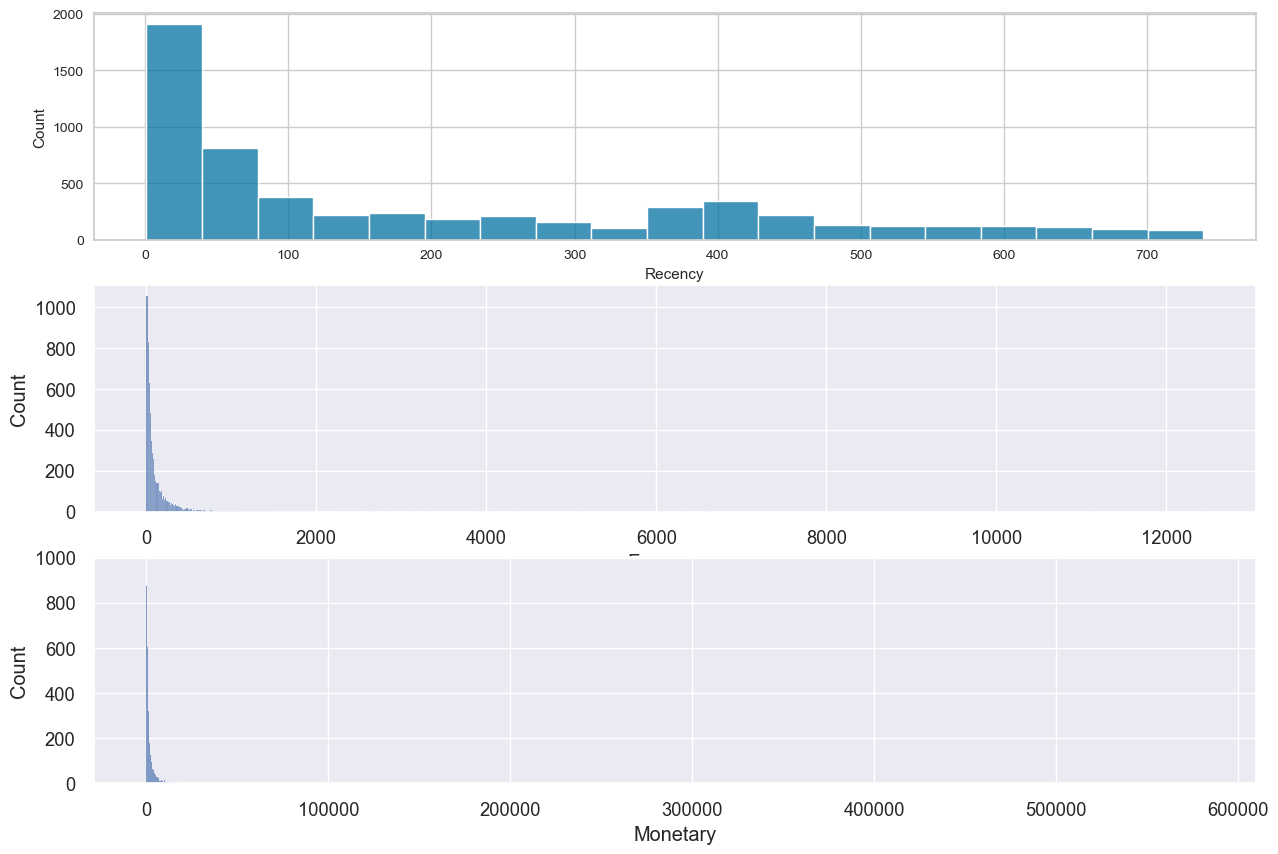

In [526]:
plt.figure(figsize=(15,10))

# Plot recency distribution
plt.subplot(3, 1, 1);
sns.set_theme(font_scale=1.2) # set theme for plots
sns.histplot(x=rfm["Recency"]);

# Plot frequency distribution
plt.subplot(3, 1, 2);
sns.set_theme(font_scale=1.2) # set theme for plots
sns.histplot(x=rfm["Frequency"]);

# Plot monetary value distribution
plt.subplot(3, 1, 3);
sns.set_theme(font_scale=1.2) # set theme for plots
sns.histplot(x=rfm["Monetary"]);


# Show the plot
plt.show()

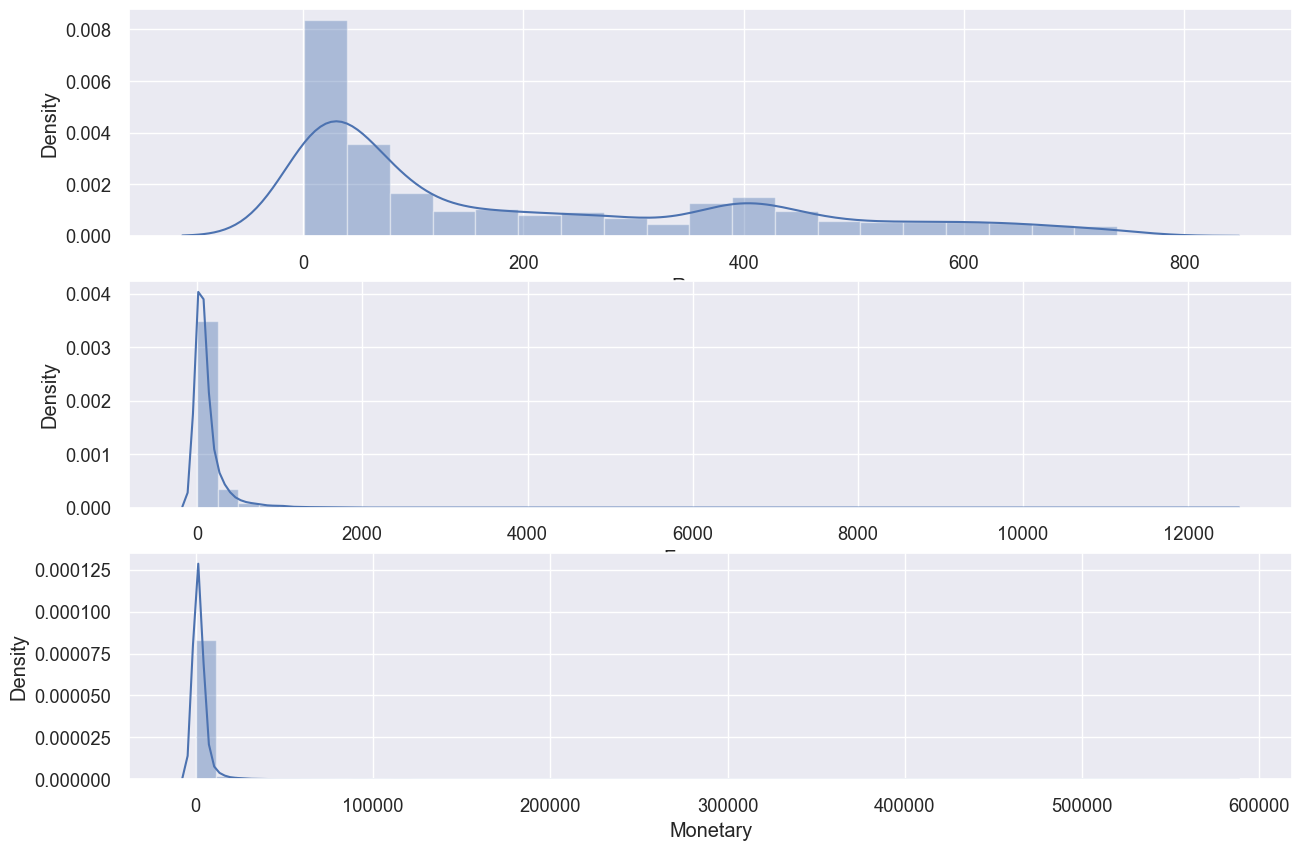

In [527]:
plt.figure(figsize=(15,10))

# Plot recency distribution
plt.subplot(3, 1, 1); sns.distplot(rfm['Recency'])

# Plot frequency distribution
plt.subplot(3, 1, 2); sns.distplot(rfm['Frequency'])

# Plot monetary value distribution
plt.subplot(3, 1, 3); sns.distplot(rfm['Monetary'])

# Show the plot
plt.show()

In [528]:
rfm[["Segment", "Recency", "Frequency", "Monetary"]].groupby("Segment").agg(["mean", "count"])

Recency       Frequency        Monetary      
           mean count      mean count      mean count
Segment                                              
11      569.484   469     7.925   469   358.860   469
12      546.046   349    24.519   349   501.064   349
13      529.927   233    51.296   233  1104.188   233
14      477.337    86   105.186    86  1579.785    86
15      484.806    31   277.484    31  3363.847    31
21      315.848   309     8.311   309   479.097   309
22      310.360   314    25.583   314   784.680   314
23      313.579   285    52.796   285   897.690   285
24      317.226   190   107.932   190  1911.180   190
25      288.961    77   321.883    77  5016.287    77
31      112.975   201     8.711   201   676.742   201
32      108.734   229    26.127   229   646.880   229
33      107.992   266    53.910   266  1386.395   266
34      110.186   301   112.688   301  2491.294   301
35      102.038   183   326.251   183  4701.492   183
41       38.050   119     9.210   119   387.805   119
42       38.512   170    26.753   170   828.801   170
43       38.519   208    54.188   208  1189.645   208
44       36.759   307   117.495   307  2231.129   307
45       35.619   336   363.098   336  6826.994   336
51       11.462    78     8.603    78  2892.413    78
52       10.912   113    26.301   113   794.225   113
53       10.788   184    54.625   184  1646.467   184
54       10.216   291   120.351   291  3089.105   291
55        8.781   549   596.135   549 14464.141   549

In [529]:
# Segment distribution
# Segment dağılımı
rfm.groupby("Segment_Label").agg(
    Count=("Segment_Label", "count"),
    Percentage=("Segment_Label", lambda x: len(x) / len(rfm) * 100)
)

,Count,Percentage
Segment_Label,,
About_to_Sleep,430,7.315
At_Risk,794,13.508
Cant_Loose,108,1.837
Champions,840,14.291
Hibernating,1441,24.515
Loyal_Customers,1127,19.173
Need_Attention,266,4.525
New_Customers,78,1.327
Potential_Loyalists,675,11.483


In [530]:
rfm_filtered = rfm[rfm["Segment_Label"] == "Champions"][["Segment_Label", "RFM_SCORE"]]
#rfm_filtered = rfm.loc[rfm["Segment_Label"] == "Champions", ["Segment_Label", "RFM_SCORE"]]

In [531]:
rfm_filtered.sort_values(["Segment_Label", "RFM_SCORE"], ascending=True)

,Segment_Label,RFM_SCORE
Customer ID,,
13428.000,Champions,542
13558.000,Champions,542
14052.000,Champions,542
14093.000,Champions,542
14954.000,Champions,542
...,...,...
18223.000,Champions,555
18225.000,Champions,555
18229.000,Champions,555


In [532]:
rfm_filtered["RFM_SCORE"].value_counts(1)

RFM_SCORE
555   0.512
544   0.164
554   0.112
545   0.089
543   0.069
553   0.030
542   0.024
Name: proportion, dtype: float64

In [533]:
counts = rfm_filtered["RFM_SCORE"].value_counts(0)  # Kategori sayıları
ratios = rfm_filtered["RFM_SCORE"].value_counts(1)  # Kategori oranları

# İkisini bir DataFrame'e dönüştürme
result = pd.DataFrame({"Count": counts, "Ratio": ratios})
result

,Count,Ratio
RFM_SCORE,,
555,430,0.512
544,138,0.164
554,94,0.112
545,75,0.089
543,58,0.069
553,25,0.030
542,20,0.024


# Cluster

In [535]:
!pip install yellowbrick

In [536]:
import pandas as pd
import argparse
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [537]:
rfm_backup = rfm.copy()
rfm_backup.head()

,Recency,Tenure,Frequency,Monetary,BasketSize,RecencyScore,FrequencyScore,MonetaryScore,TenureScore,RFM_SCORE,Segment,Segment_Label
Customer ID,,,,,,,,,,,,
12346.000,326,726,34,77556.460,2281.072,2,2,5,5,225,22,Hibernating
12347.000,3,405,222,4921.530,22.169,5,5,5,2,555,55,Champions
12348.000,76,439,51,2019.400,39.596,3,3,4,3,334,33,Need_Attention
12349.000,19,590,175,4428.690,25.307,5,5,5,3,555,55,Champions
12350.000,311,311,17,334.400,19.671,2,2,2,2,222,22,Hibernating


In [538]:
rfm = rfm_backup.copy()
rfm = rfm.reset_index()

In [539]:
rfm.head()

,Customer ID,Recency,Tenure,Frequency,Monetary,BasketSize,RecencyScore,FrequencyScore,MonetaryScore,TenureScore,RFM_SCORE,Segment,Segment_Label
0,12346.000,326,726,34,77556.460,2281.072,2,2,5,5,225,22,Hibernating
1,12347.000,3,405,222,4921.530,22.169,5,5,5,2,555,55,Champions
2,12348.000,76,439,51,2019.400,39.596,3,3,4,3,334,33,Need_Attention
3,12349.000,19,590,175,4428.690,25.307,5,5,5,3,555,55,Champions
4,12350.000,311,311,17,334.400,19.671,2,2,2,2,222,22,Hibernating


In [540]:
# rfm_set = rfm.set_index("Customer ID")
# rfm_set.head()

In [541]:
segment_data = rfm[["RecencyScore", "FrequencyScore", "MonetaryScore", "TenureScore"]]
segment_data.head()

,RecencyScore,FrequencyScore,MonetaryScore,TenureScore
0,2,2,5,5
1,5,5,5,2
2,3,3,4,3
3,5,5,5,3
4,2,2,2,2


In [542]:
segment_data.index

RangeIndex(start=0, stop=5878, step=1)

In [543]:
segment_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5878 entries, 0 to 5877
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   RecencyScore    5878 non-null   category
 1   FrequencyScore  5878 non-null   category
 2   MonetaryScore   5878 non-null   category
 3   TenureScore     5878 non-null   category
dtypes: category(4)
memory usage: 23.9 KB


In [544]:
# [segment_data[col].astype(int) for col in segment_data.columns if segment_data[col].dtype.name == "category"]

segment_data = segment_data.apply(lambda col: col.astype(int) if col.dtype.name == "category" else col)

In [545]:
segment_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5878 entries, 0 to 5877
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   RecencyScore    5878 non-null   int64
 1   FrequencyScore  5878 non-null   int64
 2   MonetaryScore   5878 non-null   int64
 3   TenureScore     5878 non-null   int64
dtypes: int64(4)
memory usage: 183.8 KB


# Clustering Level

In [547]:
K = range(2, 12)

In [548]:
# for i in K:
#     print(i)

In [549]:
# 4 küme ile bir deneme yapıyoruz
kmeans = KMeans(n_clusters=4).fit(segment_data)

In [550]:
print(kmeans.inertia_)

16720.765143271266


26775.094380159226
20110.54627061705
16721.650166157186
13711.606096504865
12694.539843317314
11540.731535747105
10484.703250107934
10176.92134287225
9420.387891393166
8948.85966232677


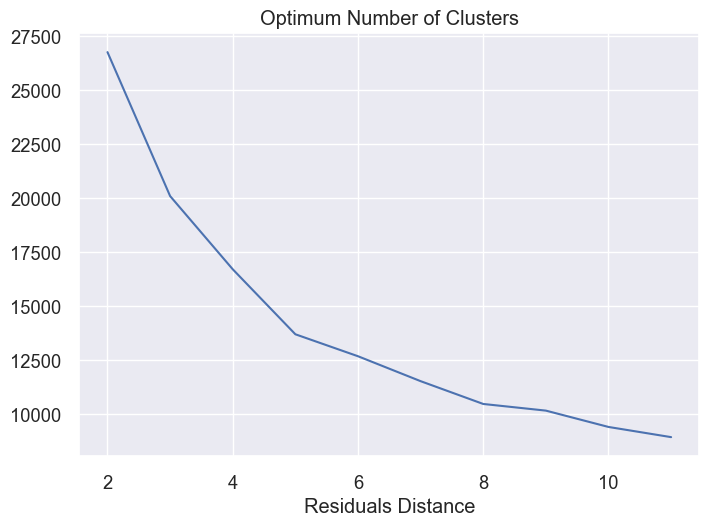

In [551]:
#kmeans = KMeans()
ssd = []
K = range(2, 12)

for k in K:
    kmeans = KMeans(n_clusters=k).fit(segment_data)
    print(kmeans.inertia_)
    ssd.append(kmeans.inertia_)
    
    
plt.plot(K, ssd, "bx-")
plt.xlabel("Residuals Distance")
plt.title("Optimum Number of Clusters")
plt.show()    

#Inertia measures how well a dataset was clustered by K-Means. 
#It is calculated by measuring the distance between each data point and its centroid, 
#squaring this distance, and summing these squares across one cluster. 

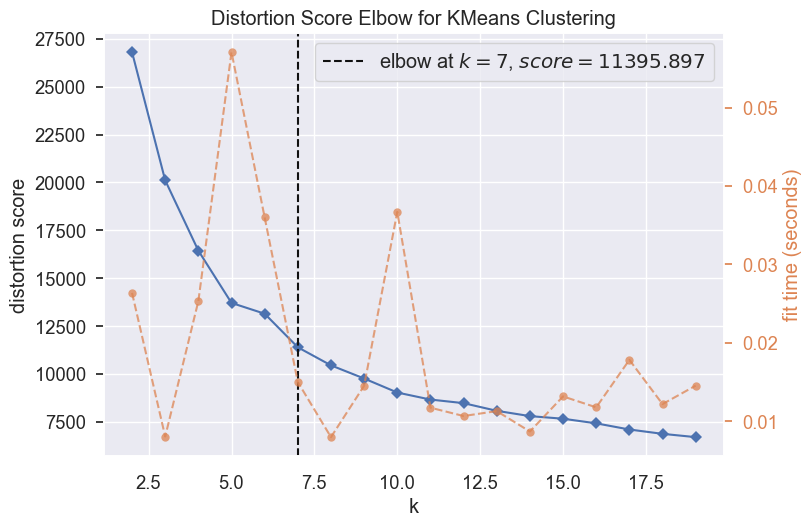

In [552]:
kmeans = KMeans(n_clusters=k, random_state=19).fit(segment_data)
elbow = KElbowVisualizer(kmeans, k=(2, 20))
elbow.fit(segment_data)
elbow.show();

In [553]:
kmeans = KMeans(n_clusters=7).fit(segment_data)

In [554]:
kmeans.labels_

array([3, 5, 3, ..., 2, 3, 5], dtype=int32)

In [555]:
segment_data["clusters"] = kmeans.labels_
segment_data.head()

,RecencyScore,FrequencyScore,MonetaryScore,TenureScore,clusters
0,2,2,5,5,3
1,5,5,5,2,5
2,3,3,4,3,3
3,5,5,5,3,5
4,2,2,2,2,6


In [556]:
segment_data["clusters"].value_counts()

clusters
0    995
3    975
1    850
6    782
4    779
2    755
5    742
Name: count, dtype: int64

In [557]:
segmentation = rfm.join(segment_data[['clusters']])

In [558]:
segmentation.head(10)

,Customer ID,Recency,Tenure,Frequency,Monetary,BasketSize,RecencyScore,FrequencyScore,MonetaryScore,TenureScore,RFM_SCORE,Segment,Segment_Label,clusters
0,12346.000,326,726,34,77556.460,2281.072,2,2,5,5,225,22,Hibernating,3
1,12347.000,3,405,222,4921.530,22.169,5,5,5,2,555,55,Champions,5
2,12348.000,76,439,51,2019.400,39.596,3,3,4,3,334,33,Need_Attention,3
3,12349.000,19,590,175,4428.690,25.307,5,5,5,3,555,55,Champions,5
4,12350.000,311,311,17,334.400,19.671,2,2,2,2,222,22,Hibernating,6
5,12351.000,376,376,21,300.930,14.330,2,2,2,2,222,22,Hibernating,6
6,12352.000,37,393,103,2849.840,27.668,4,4,4,2,444,44,Loyal_Customers,5
7,12353.000,205,409,24,406.760,16.948,2,2,2,2,222,22,Hibernating,6
8,12354.000,233,233,58,1079.400,18.610,2,3,3,1,233,23,At_Risk,6
9,12355.000,215,568,35,947.610,27.075,2,2,3,3,223,22,Hibernating,6


In [559]:
segmentation.groupby("clusters").agg({'Recency': ['mean'],'Frequency': ['mean'], 'Monetary': ['mean'], 'Tenure': ['mean'] }, ascending=True)

,Recency,Frequency,Monetary,Tenure
,mean,mean,mean,mean
clusters,,,,
0,30.734,416.795,10371.806,699.067
1,187.449,13.426,235.526,224.282
2,557.750,16.936,277.293,624.809
3,263.267,109.345,2315.448,649.015
4,41.864,49.484,1069.095,207.502
5,33.368,222.294,4033.141,381.274
6,334.404,38.978,719.087,458.183


In [560]:
segmentXclu = pd.crosstab(segmentation["Segment_Label"],segmentation["clusters"])

In [561]:
segmentXclu

clusters,0,1,2,3,4,5,6
Segment_Label,,,,,,,
About_to_Sleep,0,297,12,35,29,0,57
At_Risk,0,0,64,419,0,1,310
Cant_Loose,0,0,0,106,0,2,0
Champions,469,0,0,0,36,335,0
Hibernating,0,367,677,43,0,0,354
Loyal_Customers,478,0,0,216,69,356,8
Need_Attention,0,8,0,99,107,4,48
New_Customers,4,44,2,0,28,0,0
Potential_Loyalists,44,31,0,56,497,44,3


In [562]:
zero_clu = segmentation[segmentation["clusters"] == 0] 
zero_clu.head()

,Customer ID,Recency,Tenure,Frequency,Monetary,BasketSize,RecencyScore,FrequencyScore,MonetaryScore,TenureScore,RFM_SCORE,Segment,Segment_Label,clusters
12,12358.000,2,732,77,3887.070,50.481,5,4,5,5,545,54,Champions,0
13,12359.000,58,735,362,8873.390,24.512,4,5,5,5,455,45,Loyal_Customers,0
14,12360.000,53,656,217,4252.890,19.599,4,5,5,4,455,45,Loyal_Customers,0
16,12362.000,4,739,267,5356.230,20.061,5,5,5,5,555,55,Champions,0
24,12370.000,52,669,201,4316.560,21.475,4,5,5,4,455,45,Loyal_Customers,0


In [563]:
zero_clu.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer ID,995.000,15322.808,1695.403,12358.000,13869.500,15291.000,16801.500,18283.000
Recency,995.000,30.734,32.798,1.000,9.000,20.000,41.000,188.000
Tenure,995.000,699.067,42.157,598.000,667.000,724.000,734.000,739.000
Frequency,995.000,416.795,710.196,6.000,156.500,264.000,456.500,12435.000
Monetary,995.000,10371.806,31790.765,462.120,2776.300,4732.030,8751.285,580987.040
BasketSize,995.000,31.476,72.780,2.841,11.330,18.436,26.096,1459.440
clusters,995.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [564]:
segment_data.groupby("clusters").agg({'FrequencyScore': ['mean']}, ascending=True)

,FrequencyScore
,mean
clusters,
0,4.643
1,1.302
2,1.499
3,3.584
4,2.705
5,4.389
6,2.451


# Hierarchical - Clustering

In [566]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

In [567]:
segment_data1 = segment_data.drop(['clusters','MonetaryScore'], axis=1)
segment_data1.head()

,RecencyScore,FrequencyScore,TenureScore
0,2,2,5
1,5,5,2
2,3,3,3
3,5,5,3
4,2,2,2


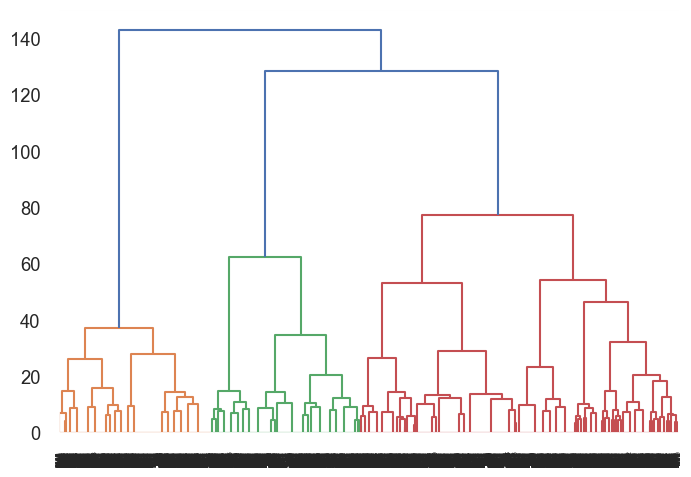

In [568]:
linkage_method = linkage(segment_data1, method ='ward', metric='euclidean')
Dendrogram = dendrogram(linkage_method);

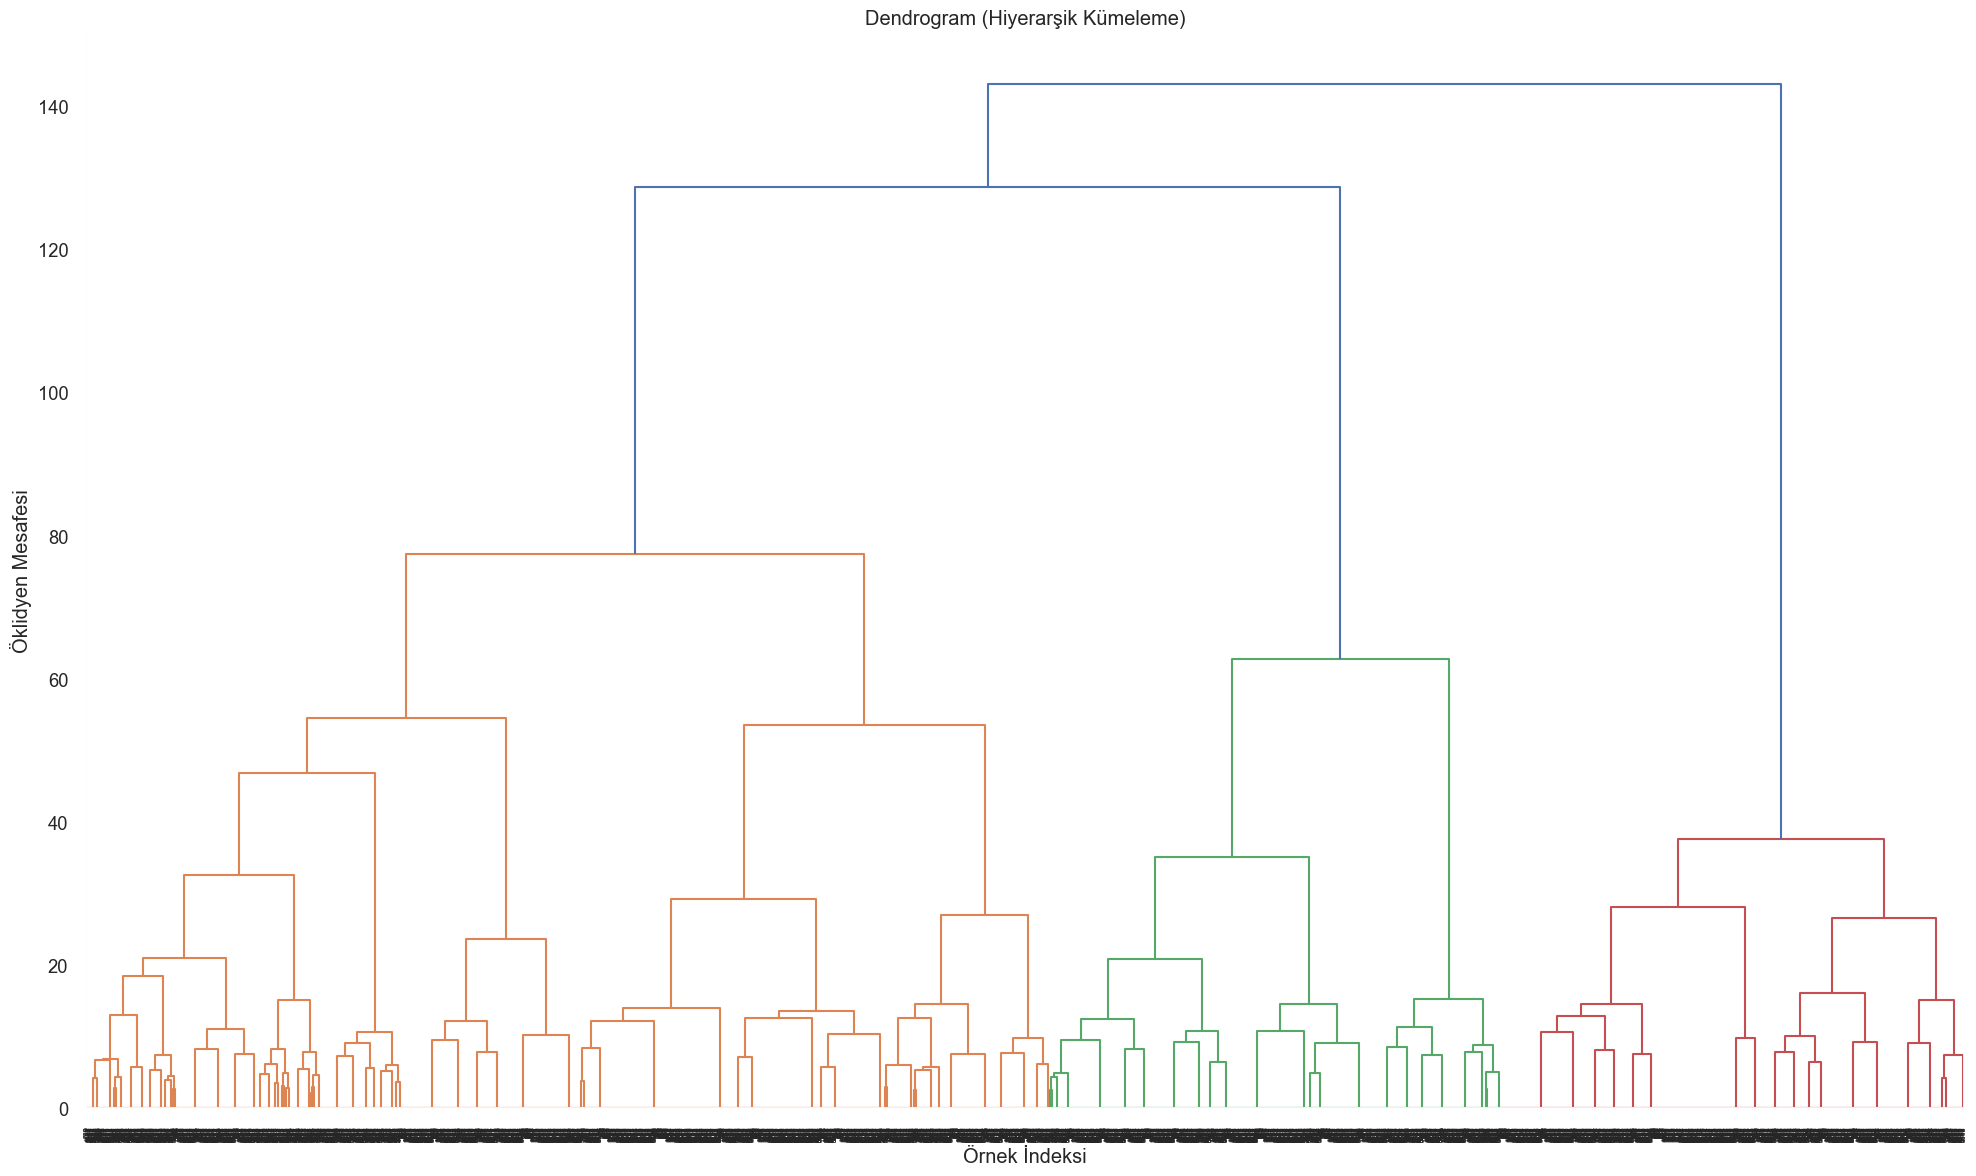

In [569]:
# 3. Dendrogram Grafiği
plt.figure(figsize=(20, 12))  # Grafik boyutunu ayarlayın
dendrogram(
    linkage_method,
    orientation='top',  # Yukarıdan aşağıya bir dendrogram
    labels=segment_data1.index.tolist(),  # Örneklerin indekslerini etiket olarak kullan
    distance_sort='descending',  # Mesafeleri azalan sırayla düzenle
    show_leaf_counts=True  # Yaprakların sayısını göster
)

# 4. Grafik Ayarları
plt.title('Dendrogram (Hiyerarşik Kümeleme)')
plt.xlabel('Örnek İndeksi')
plt.ylabel('Öklidyen Mesafesi')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 5. Göster
plt.tight_layout()
plt.show()

In [570]:
cluster_ea = AgglomerativeClustering(n_clusters=7, linkage='ward', metric='euclidean')

In [571]:
cluster_ea

AgglomerativeClustering(n_clusters=7)

In [572]:
cluster_labels = cluster_ea.fit_predict(segment_data1)

In [573]:
segment_data1["clusters_hy"] = cluster_labels

In [574]:
segment_data1

,RecencyScore,FrequencyScore,TenureScore,clusters_hy
0,2,2,5,0
1,5,5,2,4
2,3,3,3,0
3,5,5,3,1
4,2,2,2,3
...,...,...,...,...
5873,5,5,4,1
5874,1,2,2,3
5875,1,1,4,5
5876,1,3,5,5


In [575]:
seg_merged = segmentation.join(segment_data1[['clusters_hy']])

In [576]:
seg_merged.head(10)

,Customer ID,Recency,Tenure,Frequency,Monetary,BasketSize,RecencyScore,FrequencyScore,MonetaryScore,TenureScore,RFM_SCORE,Segment,Segment_Label,clusters,clusters_hy
0,12346.000,326,726,34,77556.460,2281.072,2,2,5,5,225,22,Hibernating,3,0
1,12347.000,3,405,222,4921.530,22.169,5,5,5,2,555,55,Champions,5,4
2,12348.000,76,439,51,2019.400,39.596,3,3,4,3,334,33,Need_Attention,3,0
3,12349.000,19,590,175,4428.690,25.307,5,5,5,3,555,55,Champions,5,1
4,12350.000,311,311,17,334.400,19.671,2,2,2,2,222,22,Hibernating,6,3
5,12351.000,376,376,21,300.930,14.330,2,2,2,2,222,22,Hibernating,6,3
6,12352.000,37,393,103,2849.840,27.668,4,4,4,2,444,44,Loyal_Customers,5,4
7,12353.000,205,409,24,406.760,16.948,2,2,2,2,222,22,Hibernating,6,3
8,12354.000,233,233,58,1079.400,18.610,2,3,3,1,233,23,At_Risk,6,3
9,12355.000,215,568,35,947.610,27.075,2,2,3,3,223,22,Hibernating,6,3


In [577]:
clu_compare = pd.crosstab(seg_merged["clusters_hy"],seg_merged["clusters"])
clu_compare

clusters,0,1,2,3,4,5,6
clusters_hy,,,,,,,
0,48,26,66,561,70,24,188
1,947,0,0,216,5,278,7
2,0,449,0,0,497,20,9
3,0,367,255,3,0,1,348
4,0,0,0,0,73,365,0
5,0,0,434,95,0,0,0
6,0,8,0,100,134,54,230
